In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [91]:


def mse_loss(y_true,y_pred):
    """
    Compute the mean squared error loss between the true and predicted values (the cost function)
    """
    return np.mean(np.square(y_true-y_pred))
    

def derivative_mse_loss(y_true,y_pred):
    """
    Compute the derivative of the mean squared error loss function with respect to the predicted values
    input:
    y_true: numpy array, dimensions (batch_size,seq_len,d_model), the true values
    y_pred: numpy array, dimensions (batch_size,seq_len,d_model), the predicted values
    output:
    numpy array, dimensions (batch_size,seq_len,d_model), the derivative of the loss function with respect to the predicted values 
    """

    return 2*(y_pred-y_true)/y_true.shape[0]
def Relu(x):
    return np.maximum(0,x)
def Relu_derivative(x):
    return np.where(x>0,1,0)
class TransfomerFF:
    def __init__(self,d_model=4,max_seq_len=100,units=2048,batch_size=32,name="FF_layer_X"):
            self.d_model = d_model
            self.max_seq_len = max_seq_len
            self.batch_size = batch_size
            self.weights1 = None
            self.weights2 = None
            self.bias1 = None
            self.bias2 = None
            self.name = name
            self.units = units # the number of units in the hidden layer
    def init_weights(self,weights_mode="random",weights1=None,weights2=None,bias1=None,bias2=None):
        """
        Initialize the weights of the model
        
        Parameters:
        
        weights_mode: str, the mode of the weights initialization, can be "random" or "pretrained"
        weights1: numpy array, the weights of the first layer
        weights2: numpy array, the weights of the second layer
        bias1: numpy array, the bias of the first layer
        bias2: numpy array, the bias of the second layer
        
        """
        
        if weights_mode=="random":
            self.weights1 = np.random.randn(self.d_model,self.units)*0.01
            self.weights2 = np.random.randn(self.units,self.d_model)*0.01
            self.bias1 = np.zeros((1, self.units)) #np.random.randn(1,self.units)
            self.bias2 =  np.zeros((1, self.d_model)) #  np.random.randn(1,self.d_model)
        elif weights_mode=="pretrained":
            # check if the weights are provided and if they are of the correct shape
            if (weights1 is None or weights2 is None or 
                bias1 is None or bias2 is None):
                raise ValueError("weights1, weights2, bias1, and bias2 must be provided for pretrained mode.")
            assert weights1.shape == (self.d_model,self.units)
            assert weights2.shape == (self.units,self.d_model)
            assert bias1.shape == (1,self.units)
            assert bias2.shape == (1,self.d_model)
            
            self.weights1 = weights1
            self.weights2 = weights2
            self.bias1 = bias1
            self.bias2 = bias2
            
        elif weights_mode == "null":
            self.weights1 = np.zeros((self.d_model,self.units))
            self.weights2 = np.zeros((self.units,self.d_model))
            self.bias1 = np.zeros((1,self.units))
            self.bias2 = np.zeros((1,self.d_model))
    def forward_no_batch(self, inputs):
        # inputs shape: (seq_len,d_model)
        z1 = np.dot(inputs,self.weights1) + self.bias1
        a1 = Relu(z1)
        z2 = np.dot(a1,self.weights2) + self.bias2
        return z2
    def forward(self, inputs):
        """
        inputs: numpy array, dimensions (batch_size, max_seq_len, d_model), the input data
        
        Returns:
        numpy array, dimensions (batch_size, max_seq_len, d_model), the output of the layer
        """
        
        # X shape: (batch_size, max_seq_len, d_model)
        self.batch_size, self.max_seq_len, _ = inputs.shape
        # Reshape X to 2D for easier computation
        X_reshaped = inputs.reshape(-1, self.d_model)
        # First layer
        self.Z1 = np.dot(X_reshaped, self.weights1) + self.bias1
        
        # apply the activation function 
        self.A1 = np.maximum(0, self.Z1)  # ReLU activation
            
        # Second layer
        Z2 = np.dot(self.A1, self.weights2) + self.bias2
            
        # Reshape output back to 3D
        return Z2.reshape(self.batch_size, self.max_seq_len, self.d_model)
    
    def backprop(self,inputs,targets):
        
        """
        inputs: numpy array, dimensions (seq_len,d_model), the input data
        targets: numpy array, dimensions (seq_len,d_model), the target values
        """
        
        # create the gradient arrays
        grad_weights1 = np.zeros_like(self.weights1)
        grad_weights2 = np.zeros_like(self.weights2)
        grad_bias1 = np.zeros_like(self.bias1)
        grad_bias2 = np.zeros_like(self.bias2)
        

        
        
        
        # feed forward pass
        
        z_layer_1 = np.dot(inputs,self.weights1) + self.bias1
        a_layer_1 = Relu(z_layer_1)
        
        z_layer_2 = np.dot(a_layer_1,self.weights2) + self.bias2

        # delta is gradient of the cost with respect to z at the output layer ( using BP1 formula)
        
        delta=derivative_mse_loss(targets,z_layer_2) 
        
        grad_weights2 = np.dot(a_layer_1.T,delta) # or np.dot(delta,a_layer_1.T) TO VERIFY THE DIMENSIONS
        grad_bias2 = delta.sum(axis=0,keepdims=True)
        #grad_bias2 = delta
        
        delta = np.dot(delta,self.weights2.T) * Relu_derivative(z_layer_1)
        grad_weights1 = np.dot(inputs.T,delta)
        grad_bias1 = delta.sum(axis=0,keepdims=True)
        #grad_bias1 = delta
        
        return [grad_weights1,grad_weights2,grad_bias1,grad_bias2]
        
    def backprop_with_batch(self,inputs,targets):
        """
        inputs: numpy array, dimensions (batch_size,seq_len,d_model), the input data
        targets: numpy array, dimensions (batch_size,seq_len,d_model), the target values
        """
        grad_weights1 = np.zeros((inputs.shape[0],self.weights1.shape[0],self.weights1.shape[1]))
        grad_weights2 = np.zeros((inputs.shape[0],self.weights2.shape[0],self.weights2.shape[1]))
        grad_bias1 = np.zeros((inputs.shape[0],self.bias1.shape[0],self.bias1.shape[1]))
        grad_bias2 = np.zeros((inputs.shape[0],self.bias2.shape[0],self.bias2.shape[1]))
        
        # feed forward pass
        
        z_layer_1 = np.dot(inputs,self.weights1) + self.bias1
        a_layer_1 = Relu(z_layer_1)
        
        z_layer_2 = np.dot(a_layer_1,self.weights2) + self.bias2
        
         # delta is gradient of the cost with respect to z at the output layer ( using BP1 formula)
        
        delta=derivative_mse_loss(targets,z_layer_2) 
        
        #print("delta 1 shape is", delta.shape)
        #print("a_layer_1 shape is ",a_layer_1.shape)
        
        grad_weights2 = np.matmul(a_layer_1.transpose(0,2,1),delta) 
        grad_bias2 = delta.sum(axis=1,keepdims=True)

        #print("delta 2 shape is", delta.shape)
        #print("weights2 shapes is",self.weights2.T.shape)
        
        delta = np.dot(delta,self.weights2.T) * Relu_derivative(z_layer_1)
        #print("delta out",delta.shape)
        grad_weights1 = np.matmul(inputs.transpose(0,2,1),delta)
        grad_bias1 = delta.sum(axis=1,keepdims=True)
        
        
        return [grad_weights1,grad_weights2,grad_bias1,grad_bias2]
    def update_weights_batch(self,parameters,learning_rate=0.01):
        
        grad_weights1 = parameters[0].mean(axis=0)  # Average across the batch dimension
        grad_weights2 = parameters[1].mean(axis=0)
        grad_bias1 = parameters[2].mean(axis=0)
        grad_bias2 = parameters[3].mean(axis=0)

        # Update weights and biases
        self.weights1 -= learning_rate * grad_weights1
        self.weights2 -= learning_rate * grad_weights2
        self.bias1 -= learning_rate * grad_bias1
        self.bias2 -= learning_rate * grad_bias2
    def update_weights(self,parameters,learning_rate=0.01):
        self.weights1 -= learning_rate*parameters[0]
        self.weights2 -= learning_rate*parameters[1]
        self.bias1 -= learning_rate*parameters[2]
        self.bias2 -= learning_rate*parameters[3]
    
    def predict(self,inputs):
        return self.forward(inputs)
    def train(self,x,y,epoch=1001,learning_rate=0.1):
        
        # x: numpy array, dimensions (batch_size,seq_len,d_model), the input data
        loss_to_epoch_history=[]
        
        for epoch in range(epoch):
            pred=self.forward_no_batch(x)
            loss=mse_loss(y,pred)
            loss_to_epoch_history.append((epoch,loss))
            if epoch%100==0:
                print(f"Epoch:{epoch}, Loss:{loss}")
            params=self.backprop(x,y)
            self.update_weights(params,learning_rate)
        plt.plot(*zip(*loss_to_epoch_history))
        plt.show()
        return [self.weights1,self.weights2,self.bias1,self.bias2],loss_to_epoch_history
    def train_single_batch(self,x,y,epoch=1001,learning_rate=0.1):
        
        # x: numpy array, dimensions (batch_size,seq_len,d_model), the input data
        loss_to_epoch_history=[]
        
        for epoch in range(epoch):
            pred=self.forward(x)
            loss=mse_loss(y,pred)
            loss_to_epoch_history.append((epoch,loss))
            if epoch%100==0:
                print(f"Epoch:{epoch}, Loss:{loss}")
            params=self.backprop_with_batch(x,y)
            self.update_weights_batch(params,learning_rate)
        plt.plot(*zip(*loss_to_epoch_history))
        plt.show()
        return [self.weights1,self.weights2,self.bias1,self.bias2],loss_to_epoch_history

d_model=10
max_seq_len=100
units=1000
learning_rate=0.001
batch_size=8

ffn=TransfomerFF(d_model=d_model,max_seq_len=max_seq_len,units=units) 
ffn.init_weights(weights_mode="random")
X_train = np.random.randn(batch_size,max_seq_len, d_model) # 100 samples, each with d_model features
y_train = np.random.randn(batch_size,max_seq_len,d_model)  # 100 target values


#ffn.forward(X_train).shape
ffn.train_single_batch(X_train, y_train, epoch=10001, learning_rate=learning_rate)
ffn.predict(X_train).shape
print(y_train.shape)

Epoch:0, Loss:0.9868478913648288
Epoch:100, Loss:0.9789815560370551
Epoch:200, Loss:0.9730475506794434
Epoch:300, Loss:0.96679981297544
Epoch:400, Loss:0.9608183310627119
Epoch:500, Loss:0.9555155539325126
Epoch:600, Loss:0.9506816220687381
Epoch:700, Loss:0.9459695517957531
Epoch:800, Loss:0.9410975041195973
Epoch:900, Loss:0.9358993746998564
Epoch:1000, Loss:0.9302755642004384
Epoch:1100, Loss:0.9242238789834458
Epoch:1200, Loss:0.9178095309968604
Epoch:1300, Loss:0.9111190099642515
Epoch:1400, Loss:0.904286139629759
Epoch:1500, Loss:0.8974146345934538
Epoch:1600, Loss:0.8906408346657985
Epoch:1700, Loss:0.8840563809058363
Epoch:1800, Loss:0.877749845564996
Epoch:1900, Loss:0.8717335252779187
Epoch:2000, Loss:0.8660471549336051
Epoch:2100, Loss:0.8606636605511001
Epoch:2200, Loss:0.8555546617909899
Epoch:2300, Loss:0.8507067659489294


KeyboardInterrupt: 

Epoch:0, Loss:0.9947490378648288
Epoch:100, Loss:0.9882316035105664
Epoch:200, Loss:0.9831880898619964
Epoch:300, Loss:0.9790343401239254
Epoch:400, Loss:0.9754180452827105
Epoch:500, Loss:0.9720979776284826
Epoch:600, Loss:0.9689241175114656
Epoch:700, Loss:0.9657841182825253
Epoch:800, Loss:0.9626007514287619
Epoch:900, Loss:0.959325092925223
Epoch:1000, Loss:0.9559269193071426


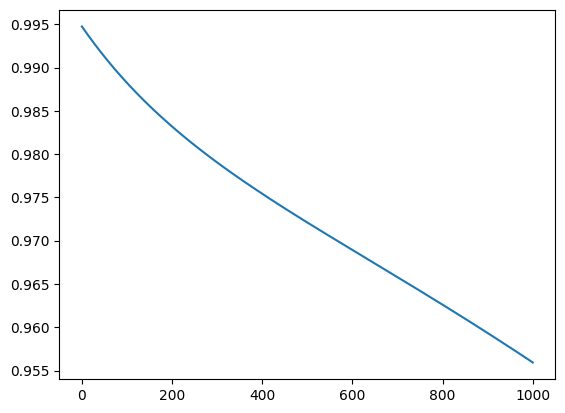

(100, 10)


In [89]:
d_model=10
max_seq_len=100
units=1000
learning_rate=0.001
ffn=TransfomerFF(d_model=d_model,max_seq_len=max_seq_len,units=units) 
ffn.init_weights(weights_mode="random")
X_train = np.random.randn(max_seq_len, d_model) # 100 samples, each with d_model features
y_train = np.random.randn(max_seq_len,d_model)  # 100 target values


#ffn.forward(X_train).shape
ffn.train(X_train, y_train, epoch=1001, learning_rate=learning_rate)
#ffn.predict(X_train).shape
print(y_train.shape)

In [64]:
batch_size=32
seq_len=100
d_model=10
d_units=128
input_example=np.random.randn(batch_size,seq_len,d_model) 
weighs_1_example = np.random.randn(d_model,d_units)
bias_1_example = np.random.randn(1,d_units)

weighs_2_example = np.random.randn(d_units,d_model)
bias_2_example = np.random.randn(1,d_model)


z_layer_1=np.dot(input_example,weighs_1_example)+bias_1_example

a_layer_1=Relu(z_layer_1)

z_layer_2=np.dot(a_layer_1,weighs_2_example)+bias_2_example
z_layer_2

delta=derivative_mse_loss(y_train,z_layer_2)

#grad_weights2 = np.matmul(delta.transpose(0,2,1),a_layer_1)
grad_weights2 = np.dot(a_layer_1.transpose(0,2,1),delta)
grad_bias2 = delta.sum(axis=1,keepdims=True)
print("delta shape",delta.shape)
print("a_layer_1 shape",a_layer_1.shape)
print("z_layer_1 shape",z_layer_1.shape)
print("y train shape",y_train.shape)
print("grad_weights2 shape",grad_weights2.shape)

delta shape (32, 100, 10)
a_layer_1 shape (32, 100, 128)
z_layer_1 shape (32, 100, 128)
y train shape (32, 100, 10)
grad_weights2 shape (32, 128, 32, 10)


In [6]:
import numpy as np

delta = np.array([[1, 2, 3],
                 [4, 5, 6]])

result = delta.sum(axis=0, keepdims=True)

print(result)

[[5 7 9]]
